# **Build, Train and Deploy A Real-World Flower Classifier of 102 Flower Types**
## **With TensorFlow 2.3, Amazon SageMaker Python SDK 2.5.x and Custom SageMaker Training & Serving Docker Containers**

![Juv Chan Flower](https://raw.githubusercontent.com/juvchan/amazon-sagemaker-tensorflow-custom-containers/master/data/juvchan_flower.jpg)

### Author: **Juv Chan Kae Siang**
### Last Updated: **9 September 2020**

## **Introduction**

This [Jupyter Notebook](https://jupyter.org/) shows step-by-step guide on:
- Using ready-to-use [**Flower dataset**](https://www.tensorflow.org/datasets/catalog/oxford_flowers102) from [**TensorFlow Datasets**](https://www.tensorflow.org/datasets).
- Using [**Transfer Learning**](https://www.tensorflow.org/tutorials/images/transfer_learning) for **feature extraction** from a **pre-trained model** from [**TensorFlow Hub**](https://www.tensorflow.org/hub).
- Using [**tf.data**](https://www.tensorflow.org/guide/data) API to build **input pipelines** for the dataset split into **training**, **validation** and **test** datasets.
- Using [**tf.keras**](https://www.tensorflow.org/api_docs/python/tf/keras) API to build, train and evaluate the model.
- Using [**Callback**](https://www.tensorflow.org/guide/keras/custom_callback) to define **early stopping** threshold for model training.
- Preparing [**training script**](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/using_tf.html#id1) to train and export the model in [**SavedModel**](https://www.tensorflow.org/guide/saved_model) format for deploy with **TensorFlow 2.x** and [**Amazon SageMaker Python SDK 2.x**](https://sagemaker.readthedocs.io/en/stable/v2.html).
- Preparing **inference code** and configuration to run the [**TensorFlow Serving ModelServer**](https://www.tensorflow.org/tfx/serving/serving_advanced) for serving the model.
- Building custom [**Docker Containers**](https://www.docker.com/resources/what-container) for training and serving the **TensorFlow model** with [**Amazon SageMaker Python SDK**](https://docs.aws.amazon.com/sagemaker/latest/dg/build-container-to-train-script-get-started.html) and [**SageMaker TensorFlow Training Toolkit**](https://github.com/aws/sagemaker-tensorflow-training-toolkit) in **Local mode**.

To get started, it is recommended to create a new isolated Python virtual environment with [Virtualenv](https://virtualenv.pypa.io/en/latest/) or [Conda](https://docs.conda.io/projects/conda/en/latest/user-guide/concepts/environments.html).<br>Install the required Python packages from the command below.

In [1]:
!pip install --upgrade pip --quiet
!pip install --upgrade sagemaker 'sagemaker[local]' tensorflow-gpu tensorflow-datasets \
jupyterlab pandas Pillow matplotlib --use-feature=2020-resolver --quiet

In [2]:
import os
import platform
import sagemaker
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import PIL.Image as Image
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import re

print(f'Amazon SageMaker Python SDK version: {sagemaker.__version__}')
print(f'Python version: {platform.python_version()}')
print(f'TensorFlow version: {tf.__version__}')
print(f'TensorFlow Datasets version: {tfds.__version__}')
print(f'NumPy version: {np.__version__}')
print(f'Pillow version: {Image.__version__}')
print(f'Pandas version: {pd.__version__}')
print(f'Matplotlib version: {matplotlib.__version__}')
print()

Amazon SageMaker Python SDK version: 2.5.3
Python version: 3.8.5
TensorFlow version: 2.3.0
TensorFlow Datasets version: 3.2.1
NumPy version: 1.18.5
Pillow version: 7.2.0
Pandas version: 1.1.1
Matplotlib version: 3.3.1



There are a total of **195** ready-to-use datasets available in the **TensorFlow Datasets (TFDS)** to date.<br>
There are **2 flower datasets** in TFDS: **oxford_flowers102**, **tf_flowers**<br>
The [**oxford_flowers102**](https://www.tensorflow.org/datasets/catalog/oxford_flowers102) dataset is used because it has both larger dataset size and larger number of flower categories.

In [3]:
tfds.disable_progress_bar()
tfds_list = tfds.list_builders()
print(f'Total number of datasets in TFDS: {len(tfds.list_builders())}')
print(f"Flower datasets in TFDS: {[name for name in tfds_list if 'flowers' in name]}")

Total number of datasets in TFDS: 195
Flower datasets in TFDS: ['oxford_flowers102', 'tf_flowers']


## **Oxford Flowers 102 Dataset Summary**

Below is some of the key information and visualization on **oxford_flowers102**.<br>
Note that the test split is used as the training examples instead of the train split because it has a much larger number of examples.

Dataset name: oxford_flowers102
Dataset version: 2.1.1
Dataset URL: https://www.tensorflow.org/datasets/catalog/oxford_flowers102
Description:
The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
in the United Kingdom. Each class consists of between 40 and 258 images. The images have
large scale, pose and light variations. In addition, there are categories that have large
variations within the category and several very similar categories.

The dataset is divided into a training set, a validation set and a test set.
The training set and validation set each consist of 10 images per class (totalling 1020 images each).
The test set consists of the remaining 6149 images (minimum 20 per class).

Number of flower types: 102
Number of training examples: 6149
Number of validation examples: 1020
Number of test examples: 1020

Flower types full list:
['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lil

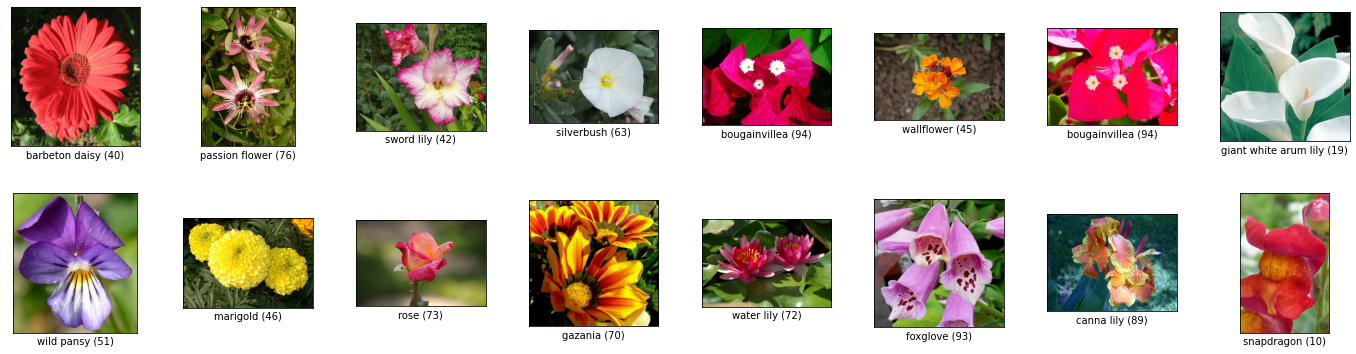

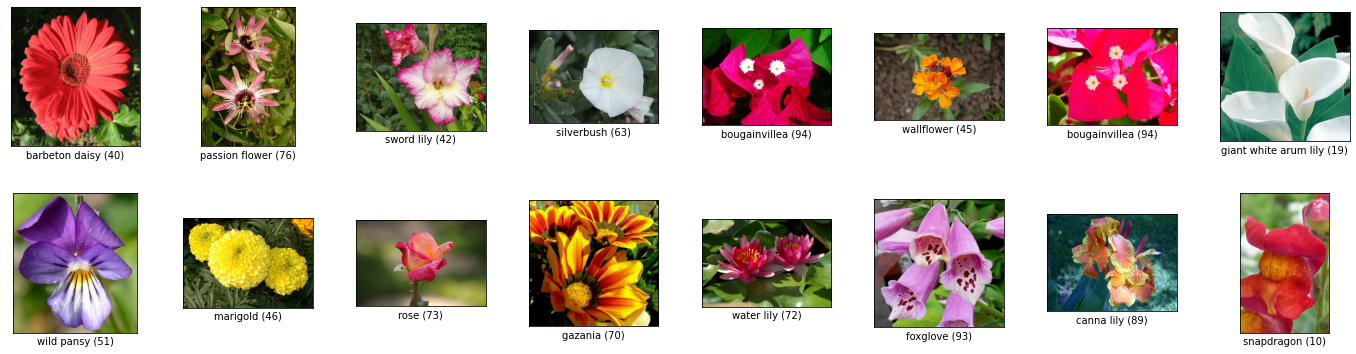

In [4]:
TFDS_DATASET_NAME = 'oxford_flowers102'
TFDS_DATASET_URL = 'https://www.tensorflow.org/datasets/catalog/oxford_flowers102'

splits = ['test', 'validation', 'train']
ds, info = tfds.load(TFDS_DATASET_NAME, split = splits, with_info=True)
(train_examples, validation_examples, test_examples) = ds

print(f'Dataset name: {info.name}')
print(f'Dataset version: {info.version}')
print(f'Dataset URL: {TFDS_DATASET_URL}')
print('Description:')
print(f'{info.description}')
print()

print(f"Number of flower types: {info.features['label'].num_classes}")
print(f"Number of training examples: {tf.data.experimental.cardinality(train_examples)}")
print(f"Number of validation examples: {tf.data.experimental.cardinality(validation_examples)}")
print(f"Number of test examples: {tf.data.experimental.cardinality(test_examples)}")
print()

print('Flower types full list:')
print(info.features['label'].names)
print()

tfds.show_examples(train_examples, info, rows=2, cols=8)

## **Create Python Training Script and Inference Code for SageMaker**

**Amazon SageMaker** allows users to use training script or inference code in the same way that would be used outside SageMaker to run custom training or inference algorithm.<br>One of the differences is that the training script used with Amazon SageMaker could make use of the [**SageMaker Containers Environment Variables**](https://github.com/aws/sagemaker-containers#important-environment-variables), e.g. **SM_MODEL_DIR**, **SM_NUM_GPUS**, **SM_NUM_CPUS** in the SageMaker container.

> Amazon SageMaker always uses Docker containers when running scripts, training algorithms or deploying models. Amazon SageMaker provides containers for its built-in algorithms and pre-built Docker images for some of the most common machine learning frameworks.  You can also create your own container images to manage more advanced use cases not addressed by the containers provided by Amazon SageMaker.

The custom training script is as shown below:

In [5]:
!pygmentize -l python container/code/train.py

import argparse
import numpy as np
import os
import logging
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds


EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.3
EARLY_STOPPING_TRAIN_ACCURACY = 0.995
TF_AUTOTUNE = tf.data.experimental.AUTOTUNE
TF_HUB_MODEL_URL = 'https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/4'
TF_DATASET_NAME = 'oxford_flowers102'
IMAGE_SIZE = (299, 299)
SHUFFLE_BUFFER_SIZE = 473
MODEL_VERSION = '1'


class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > EARLY_STOPPING_TRAIN_ACCURACY):
            print(
                f"\nEarly stopping at {logs.get('accuracy'):.4f} > {EARLY_STOPPING_TRAIN_ACCURACY}!\n")
            self.model.stop_training = True


def parse_args():
    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script
    parser.add_

## **Classify Flower with Transfer Learning with TensorFlow Hub (TF-Hub)**

[**TensorFlow Hub**](https://tfhub.dev/) is a library of reusable pre-trained machine learning models for transfer learning in different problem domains.<br>For this flower classification problem, we evaluate the **pre-trained image feature vectors** based on different image model architectures and datasets from TF-Hub as below for transfer learning on the **oxford_flowers102** dataset.

- [ResNet50 Feature Vector](https://tfhub.dev/tensorflow/resnet_50/feature_vector/1)
- [MobileNet V2 (ImageNet) Feature Vector](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4)
- [Inception V3 (ImageNet) Feature Vector](https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4)
- [Inception V3 (iNaturalist) Feature Vector](https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/4)

In the final training script, the **Inception V3 (iNaturalist) feature vector** pre-trained model is used for transfer learning for this problem because it performs the best compared to the others above **(~95% test accuracy over 5 epochs without fine-tune)**. This model uses the Inception V3 architecture and trained on the [**iNaturalist (iNat) 2017**](https://arxiv.org/abs/1707.06642) dataset of **over 5,000** different species of plants and animals from https://www.inaturalist.org/. In contrast, the [**ImageNet 2012**](https://www.tensorflow.org/datasets/catalog/imagenet2012) dataset has only 1,000 classes which has very few flower types.

## **Serve Flower Classifier Model with TensorFlow Serving**

**TensorFlow Serving** is a flexible, high-performance machine learning models serving system, designed for production environment. It is part of [**TensorFlow Extended (TFX)**](https://www.tensorflow.org/tfx), an end-to-end platform for deploying production Machine Learning (ML) pipelines. The [**TensorFlow Serving ModelServer binary**](https://www.tensorflow.org/tfx/serving/setup#available_binaries) is available in two variants: **tensorflow-model-server** and **tensorflow-model-server-universal**. The **TensorFlow Serving ModelServer** supports both [gRPC APIs](https://github.com/tensorflow/serving/blob/master/tensorflow_serving/apis/prediction_service.proto) and [RESTful APIs](https://www.tensorflow.org/tfx/serving/api_rest).

In the inference code, the **tensorflow-model-server** is used to serve the model via RESTful APIs from where it is exported in the SageMaker container. It is a fully optimized server that uses some platform specific compiler optimizations and should be the preferred option for users. The inference code and configuration is as shown below:

In [6]:
!pygmentize -l python container/code/serve

#!/usr/bin/env python

# This file implements the hosting solution, which just starts TensorFlow Model Serving.
import subprocess
import os

TF_SERVING_DEFAULT_PORT = 8501
MODEL_NAME = 'flowers_model'
MODEL_BASE_PATH = '/opt/ml/model'


def start_server():
    print('Starting TensorFlow Serving.')

    # link the log streams to stdout/err so they will be logged to the container logs
    subprocess.check_call(
        ['ln', '-sf', '/dev/stdout', '/var/log/nginx/access.log'])
    subprocess.check_call(
        ['ln', '-sf', '/dev/stderr', '/var/log/nginx/error.log'])

    # start nginx server
    nginx = subprocess.Popen(['nginx', '-c', '/opt/ml/code/nginx.conf'])

    # start TensorFlow Serving
    # https://www.tensorflow.org/serving/api_rest#start_modelserver_with_the_rest_api_endpoint
    tf_model_server = subprocess.call(['tensorflow_model_server',
                                       '--rest_api_port=' +
                                       str(TF_SERVING_DEFAULT_PORT),
      

In [7]:
!pygmentize -l python container/code/nginx.conf

events {
    # determines how many requests can simultaneously be served
    # https://www.digitalocean.com/community/tutorials/how-to-optimize-nginx-configuration
    # for more information
    worker_connections 2048;
}

http {
  server {
    # configures the server to listen to the port 8080
    # Amazon SageMaker sends inference requests to port 8080.
    # For more information: https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-inference-code.html#your-algorithms-inference-code-container-response
    listen 8080 deferred;
    client_max_body_size 10M;

    # redirects requests from SageMaker to TF Serving
    location /invocations {
      proxy_pass http://localhost:8501/v1/models/flowers_model:predict;
    }

    # Used by SageMaker to confirm if server is alive.
    # https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-inference-code.html#your-algorithms-inference-algo-ping-requests
    location /ping {
      return 200 "OK";
    }
  }
}


## **Build Custom Docker Image and Container for SageMaker Training and Inference**


Amazon SageMaker utilizes Docker containers to run all training jobs and inference endpoints.<br>

Amazon SageMaker provides pre-built Docker containers that support machine learning frameworks such as [**SageMaker Scikit-learn Container**](https://github.com/aws/sagemaker-scikit-learn-container), [**SageMaker XGBoost Container**](https://github.com/aws/sagemaker-xgboost-container), [**SageMaker SparkML Serving Container**](https://github.com/aws/sagemaker-sparkml-serving-container), [**Deep Learning Containers**](https://github.com/aws/deep-learning-containers) (TensorFlow, PyTorch, MXNet and Chainer) as well as [**SageMaker RL (Reinforcement Learning) Container**](https://github.com/aws/sagemaker-rl-container) for training and inference. These pre-built SageMaker containers should be sufficient for general purpose machine learning training and inference scenarios.<br>

There are some scenarios where the pre-built SageMaker containers are unable to support, e.g.
- Using unsupported machine learning framework versions
- Using third-party packages, libraries, run-times or dependencies which are not available in the pre-built SageMaker container
- Using custom machine learning algorithms  

Amazon SageMaker supports user-provided custom Docker images and containers for the advanced scenarios above.<br>Users can use any programming language, framework or packages to build their own Docker image and container that are tailored for their machine learning scenario with Amazon SageMaker.

In this flower classification scenario, custom Docker image and containers are used for the training and inference because the pre-built SageMaker TensorFlow containers do not have the packages required for the training, i.e. **tensorflow_hub** and **tensorflow_datasets**. Below is the **Dockerfile** used to build the custom Docker image.

In [8]:
!pygmentize -l docker container/Dockerfile

# Copyright 2020 Juv Chan. All Rights Reserved.
FROM tensorflow/tensorflow:2.3.0-gpu

LABEL maintainer="Juv Chan <juvchan@hotmail.com>"

RUN apt-get update && apt-get install -y --no-install-recommends nginx curl
RUN pip install --no-cache-dir --upgrade pip tensorflow-hub tensorflow-datasets sagemaker-tensorflow-training

RUN echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list
RUN curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
RUN apt-get update && apt-get install tensorflow-model-server

ENV PATH="/opt/ml/code:${PATH}"

# /opt/ml and all subdirectories are utilized by SageMaker, we use the /code subdirectory to store our user code.
COPY /code /opt/ml/code
WORKDIR /opt/ml/code

RUN chmod 755 serve


The Docker command below is used to build the custom Docker image used for both training and hosting with SageMaker for this project. You can update the Dockerfile path and Docker image name and tag based on own directory structure and naming preference.

```
docker build ./container/ -t sagemaker-custom-tensorflow-container-gpu:1.0
```

After the Docker image is built successfully, use the Docker commands below to verify the new image is listed as expected and no Docker container is running yet.


In [9]:
! docker images

REPOSITORY                                  TAG                 IMAGE ID            CREATED             SIZE
sagemaker-custom-tensorflow-container-gpu   1.0                 05ccba2c7dbb        2 hours ago         3.62GB
tensorflow/tensorflow                       2.3.0-gpu           20fd065e3887        5 weeks ago         3.15GB


In [10]:
! docker container ls -a

CONTAINER ID        IMAGE               COMMAND             CREATED             STATUS              PORTS               NAMES


## **SageMaker Training In Local Mode**

The **SageMaker Python SDK** supports [**local mode**](https://sagemaker.readthedocs.io/en/stable/overview.html#local-mode), which allows users to create estimators, train models and deploy them to their local environments. This is very useful and cost-effective for anyone who wants to prototype, build, develop and test his or her machine learning projects in a Jupyter Notebook with the SageMaker Python SDK on the local instance before running in the cloud.

The Amazon SageMaker local mode supports **local CPU instance (single and multiple-instance)** and **local GPU instance (single instance)**. It also allows users to switch seamlessly between local and cloud instances (i.e. [Amazon EC2 instance](https://aws.amazon.com/ec2/instance-types/)) by changing the **instance_type** argument for the SageMaker Estimator object (Note: This argument is previously known as **train_instance_type** in SageMaker Python SDK 1.x). Everything else works the same.

In this scenario, the local GPU instance is used by default if available, else fall back to local CPU instance. Note that the **output_path** is set to the local current directory (**file://.**) which will output the trained model artifacts to the local current directory instead of uploading onto Amazon S3. The **image_uri** is set to the local custom Docker image which is built locally so that SageMaker will not fetch from the pre-built Docker images based on framework and version. You can refer to the latest [SageMaker TensorFlow Estimator](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html) and [SageMaker Estimator Base](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) API documentations for the full details.

In addition, **hyperparameters** can be passed to the training script by setting the **hyperparameters** of the SageMaker Estimator object. The hyperparameters that can be set depend on the hyperparameters used in the training script. In this case, they are *'epochs'*, *'batch_size'* and *'learning_rate'*.

In [11]:
from sagemaker.tensorflow import TensorFlow

instance_type = 'local_gpu' # For Local GPU training. For Local CPU Training, type = 'local'

gpu = tf.config.list_physical_devices('GPU')

if len(gpu) == 0:
    instance_type = 'local'
    
print(f'Instance type = {instance_type}')

role = 'SageMakerRole' # Import get_execution_role from sagemaker and use get_execution_role() on SageMaker Notebook instance

hyperparams = {'epochs': 5}

tf_local_estimator = TensorFlow(entry_point='train.py', role=role, 
                                instance_count=1, instance_type='local_gpu', output_path='file://.',
                                image_uri='sagemaker-custom-tensorflow-container-gpu:1.0',
                                hyperparameters=hyperparams)
tf_local_estimator.fit()

Instance type = local_gpu
Creating tmpbb00tk19_algo-1-xxmq4_1 ... 
Attaching to tmpbb00tk19_algo-1-xxmq4_12mdone
algo-1-xxmq4_1  | 2020-09-05 04:37:29,559 sagemaker-training-toolkit INFO     Invoking user script
algo-1-xxmq4_1  | 
algo-1-xxmq4_1  | Training Env:
algo-1-xxmq4_1  | 
algo-1-xxmq4_1  | {
algo-1-xxmq4_1  |     "additional_framework_parameters": {},
algo-1-xxmq4_1  |     "channel_input_dirs": {},
algo-1-xxmq4_1  |     "current_host": "algo-1-xxmq4",
algo-1-xxmq4_1  |     "framework_module": null,
algo-1-xxmq4_1  |     "hosts": [
algo-1-xxmq4_1  |         "algo-1-xxmq4"
algo-1-xxmq4_1  |     ],
algo-1-xxmq4_1  |     "hyperparameters": {
algo-1-xxmq4_1  |         "epochs": 5,
algo-1-xxmq4_1  |         "model_dir": "file:/sagemaker-custom-tensorflow-container-g-2020-09-05-04-37-25-981/model"
algo-1-xxmq4_1  |     },
algo-1-xxmq4_1  |     "input_config_dir": "/opt/ml/input/config",
algo-1-xxmq4_1  |     "input_data_config": {},
algo-1-xxmq4_1  |     "input_dir": "/opt/ml/input",

## **Flower Classification Model Training & Evaluation Results**

As shown from the SageMaker training container output above, the training job is completed successfully as expected. The SageMaker training container also exited as expected.

The model evaluation results:
- Training Accuracy: **0.9961**
- Validation Accuracy: **0.9588**
- Test Accuracy: **0.9539**

In [12]:
! docker container ls -a

CONTAINER ID        IMAGE                                           COMMAND             CREATED             STATUS                     PORTS               NAMES
41a631f7fa19        sagemaker-custom-tensorflow-container-gpu:1.0   "train"             6 minutes ago       Exited (0) 4 seconds ago                       tmpbb00tk19_algo-1-xxmq4_1


## **SageMaker Local Endpoint Deployment and Model Serving**

After the SageMaker training job is completed, the Docker container that run that job will be exited. When the training is completed successfully, the trained model can be deployed to a **local SageMaker endpoint** by calling the **deploy** method of the SageMaker Estimator object and setting the **instance_type** to local instance type (i.e. **local_gpu** or **local**). 

A new Docker container will be started to run the custom inference code (i.e the **serve** program), which runs the TensorFlow Serving ModelServer to serve the model for real-time inference. The ModelServer will serve in RESTful APIs mode and expect both the request and response data in JSON format.  When the local SageMaker endpoint is deployed successfully, users can make prediction requests to the endpoint and get prediction responses in real-time.

In [13]:
tf_local_predictor = tf_local_estimator.deploy(initial_instance_count=1,
                                               instance_type=instance_type)

Attaching to tmpjkjv5oc7_algo-1-nukxt_1
algo-1-nukxt_1  | Starting TensorFlow Serving.
algo-1-nukxt_1  | 2020-09-05 04:43:54.655740: I tensorflow_serving/model_servers/server.cc:87] Building single TensorFlow model file config:  model_name: flowers_model model_base_path: /opt/ml/model
algo-1-nukxt_1  | 2020-09-05 04:43:54.655856: I tensorflow_serving/model_servers/server_core.cc:464] Adding/updating models.
algo-1-nukxt_1  | 2020-09-05 04:43:54.655870: I tensorflow_serving/model_servers/server_core.cc:575]  (Re-)adding model: flowers_model
algo-1-nukxt_1  | 2020-09-05 04:43:54.756259: I tensorflow_serving/core/basic_manager.cc:739] Successfully reserved resources to load servable {name: flowers_model version: 1}
algo-1-nukxt_1  | 2020-09-05 04:43:54.756284: I tensorflow_serving/core/loader_harness.cc:66] Approving load for servable version {name: flowers_model version: 1}
algo-1-nukxt_1  | 2020-09-05 04:43:54.756292: I tensorflow_serving/core/loader_harness.cc:74] Loading servable vers

In [14]:
!docker container ls -a

CONTAINER ID        IMAGE                                           COMMAND             CREATED             STATUS                      PORTS                    NAMES
e8ed5762b897        sagemaker-custom-tensorflow-container-gpu:1.0   "serve"             5 seconds ago       Up 4 seconds                0.0.0.0:8080->8080/tcp   tmpjkjv5oc7_algo-1-nukxt_1
41a631f7fa19        sagemaker-custom-tensorflow-container-gpu:1.0   "train"             6 minutes ago       Exited (0) 12 seconds ago                            tmpbb00tk19_algo-1-xxmq4_1


## **Predict Flower Type with External Sources of Flower Images**

To evaluate this flower classification model performance using the **accuracy** metric, different flower images from external sources which are independent of the **oxford_flowers102** dataset are used. The main sources of these test images are from websites which provide high quality free images such as [**unsplash.com**](https://unsplash.com/) and [**pixabay.com**](https://pixabay.com) as well as self-taken photos.

In [15]:
def preprocess_input(image_path):
    if (os.path.exists(image_path)):
        originalImage = Image.open(image_path)
        image = originalImage.resize((299, 299))
        image = np.asarray(image) / 255.
        image = tf.expand_dims(image,0)
        input_data = {'instances': np.asarray(image).astype(float)}
        return input_data
    else:
        print(f'{image_path} does not exist!\n')
        return None
    
def display(image, predicted_label, confidence_score, actual_label):
    fig, ax = plt.subplots(figsize=(8, 6))
    fig.suptitle(f'Predicted: {predicted_label}     Score: {confidence_score}     Actual: {actual_label}', \
                 fontsize='xx-large', fontweight='extra bold')
    ax.imshow(image, aspect='auto')
    ax.axis('off')
    plt.show()
    
def predict_flower_type(image_path, actual_label):
    input_data = preprocess_input(image_path)
    
    if (input_data):
        result = tf_local_predictor.predict(input_data)
        CLASSES = info.features['label'].names
        predicted_class_idx = np.argmax(result['predictions'][0], axis=-1)
        predicted_class_label = CLASSES[predicted_class_idx]
        predicted_score = round(result['predictions'][0][predicted_class_idx], 4)
        original_image = Image.open(image_path)
        display(original_image, predicted_class_label, predicted_score, actual_label)
    else:
        print(f'Unable to predict {image_path}!\n')
        return None

algo-1-nukxt_1  | 172.18.0.1 - - [05/Sep/2020:04:44:00 +0000] "POST /invocations HTTP/1.1" 200 1621 "-" "-"


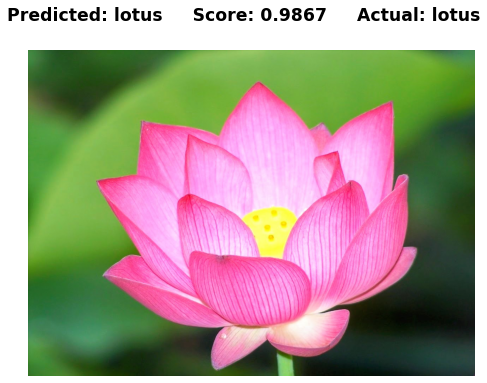

In [16]:
path = 'data/myflower.jpg'
actual = 'lotus'

predict_flower_type(path, actual)

algo-1-nukxt_1  | 172.18.0.1 - - [05/Sep/2020:04:44:00 +0000] "POST /invocations HTTP/1.1" 200 1652 "-" "-"


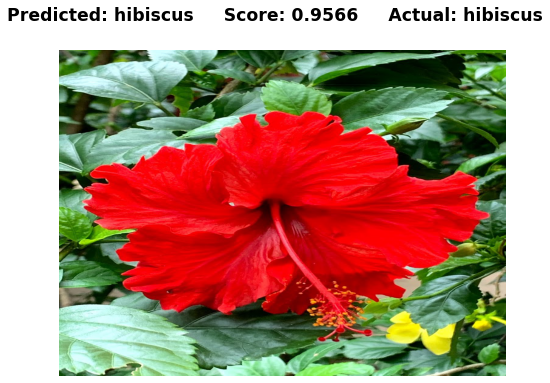

In [17]:
path = 'data/myhibuscis1.jpg'
actual = 'hibiscus'

predict_flower_type(path, actual)

algo-1-nukxt_1  | 172.18.0.1 - - [05/Sep/2020:04:44:01 +0000] "POST /invocations HTTP/1.1" 200 1639 "-" "-"


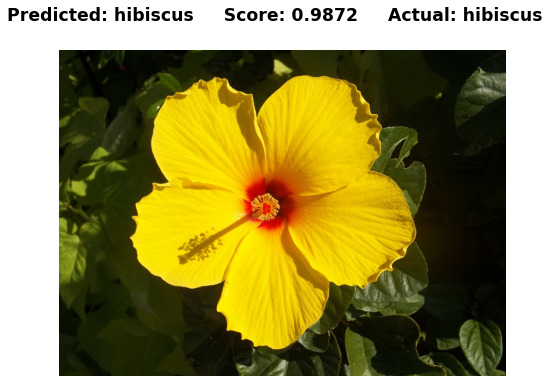

In [18]:
path = 'data/hibiscus1_pixabay.jpg'
actual = 'hibiscus'

predict_flower_type(path, actual)

algo-1-nukxt_1  | 172.18.0.1 - - [05/Sep/2020:04:44:01 +0000] "POST /invocations HTTP/1.1" 200 1644 "-" "-"


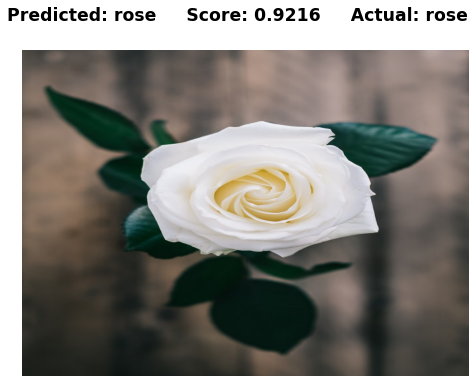

In [19]:
path = 'data/whiterose-unsplash2.jpeg'
actual = 'rose'

predict_flower_type(path, actual)

algo-1-nukxt_1  | 172.18.0.1 - - [05/Sep/2020:04:44:02 +0000] "POST /invocations HTTP/1.1" 200 1633 "-" "-"


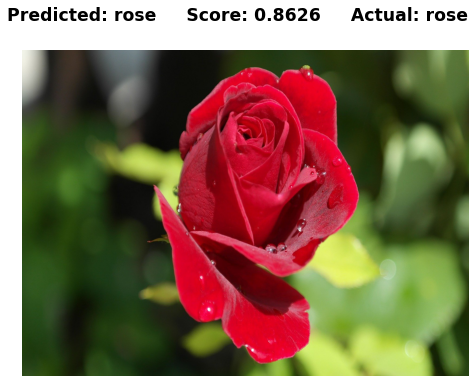

In [20]:
path = 'data/rose3_pixabay.jpg'
actual = 'rose'

predict_flower_type(path, actual)

algo-1-nukxt_1  | 172.18.0.1 - - [05/Sep/2020:04:44:03 +0000] "POST /invocations HTTP/1.1" 200 1647 "-" "-"


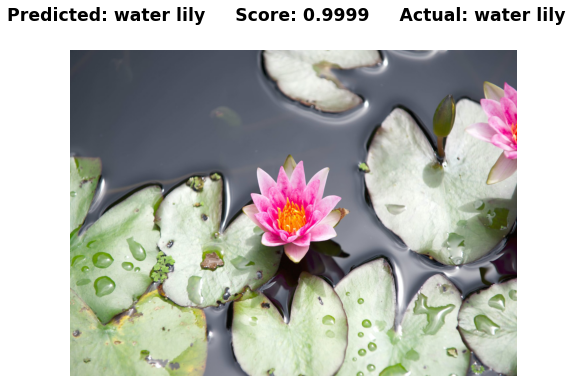

In [21]:
path = 'data/water_lily_unsplash5.jpeg'
actual = 'water lily'

predict_flower_type(path, actual)

algo-1-nukxt_1  | 172.18.0.1 - - [05/Sep/2020:04:44:03 +0000] "POST /invocations HTTP/1.1" 200 1639 "-" "-"


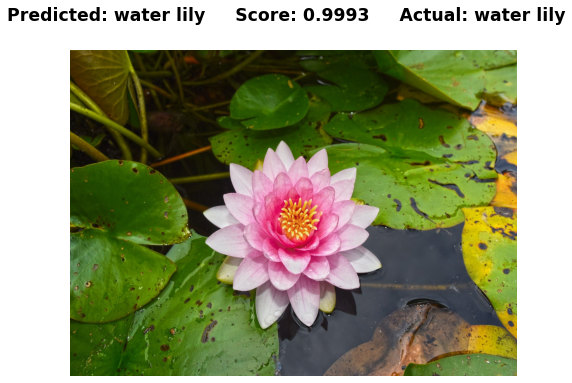

In [22]:
path = 'data/waterlily1_pixabay.jpg'
actual = 'water lily'

predict_flower_type(path, actual)

algo-1-nukxt_1  | 172.18.0.1 - - [05/Sep/2020:04:44:04 +0000] "POST /invocations HTTP/1.1" 200 1651 "-" "-"


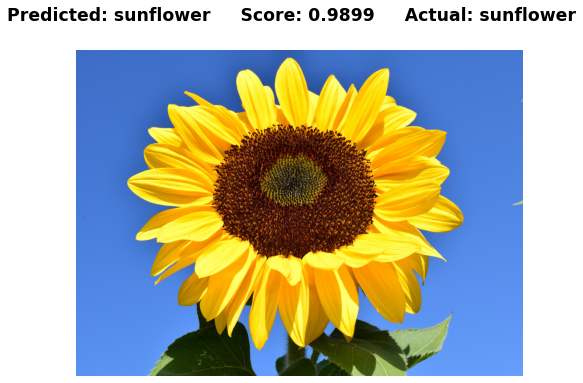

In [23]:
path = 'data/sunflower2_pixabay.jpg'
actual = 'sunflower'

predict_flower_type(path, actual)

algo-1-nukxt_1  | 172.18.0.1 - - [05/Sep/2020:04:44:05 +0000] "POST /invocations HTTP/1.1" 200 1634 "-" "-"


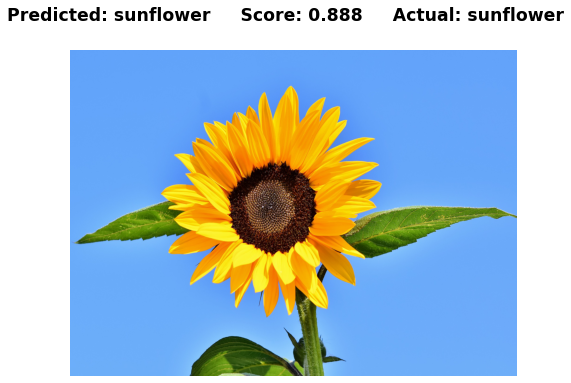

In [24]:
path = 'data/sunflower4_pixabay.jpg'
actual = 'sunflower'

predict_flower_type(path, actual)

algo-1-nukxt_1  | 172.18.0.1 - - [05/Sep/2020:04:44:05 +0000] "POST /invocations HTTP/1.1" 200 1638 "-" "-"


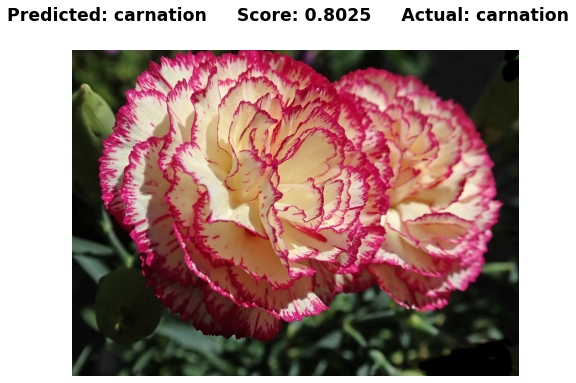

In [25]:
path = 'data/carnation5_pixabay.jpg'
actual = 'carnation'

predict_flower_type(path, actual)

algo-1-nukxt_1  | 172.18.0.1 - - [05/Sep/2020:04:44:06 +0000] "POST /invocations HTTP/1.1" 200 1630 "-" "-"


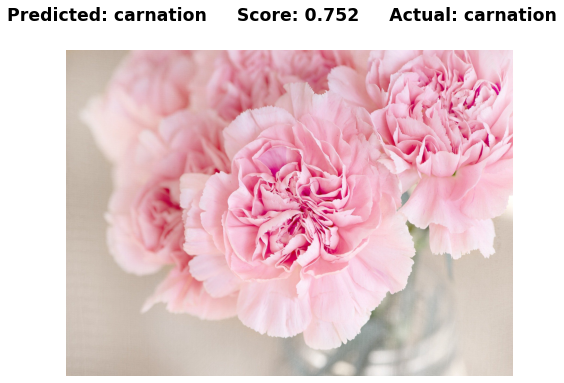

In [26]:
path = 'data/carnation7_pixabay.jpg'
actual = 'carnation'

predict_flower_type(path, actual)

algo-1-nukxt_1  | 172.18.0.1 - - [05/Sep/2020:04:44:07 +0000] "POST /invocations HTTP/1.1" 200 1645 "-" "-"


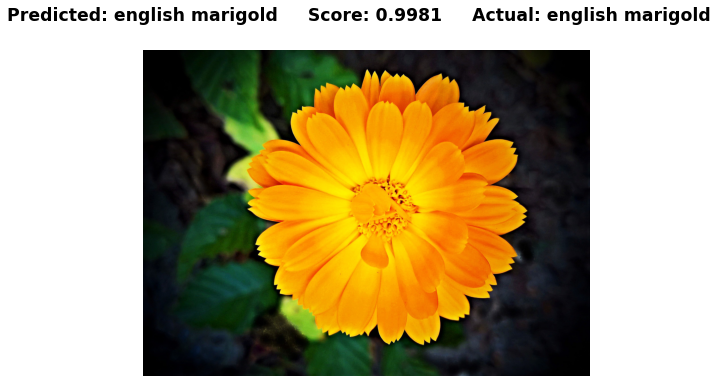

In [27]:
path = 'data/marigold_pixabay1.jpg'
actual = 'english marigold'

predict_flower_type(path, actual)

algo-1-nukxt_1  | 172.18.0.1 - - [05/Sep/2020:04:44:07 +0000] "POST /invocations HTTP/1.1" 200 1642 "-" "-"


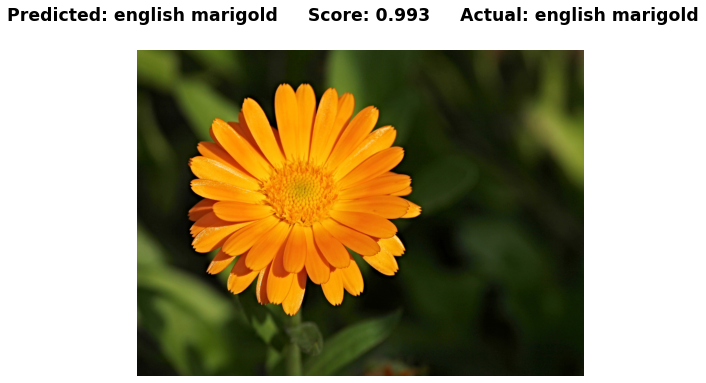

In [28]:
path = 'data/marigold_pixabay2.jpg'
actual = 'english marigold'

predict_flower_type(path, actual)

algo-1-nukxt_1  | 172.18.0.1 - - [05/Sep/2020:04:44:08 +0000] "POST /invocations HTTP/1.1" 200 1642 "-" "-"


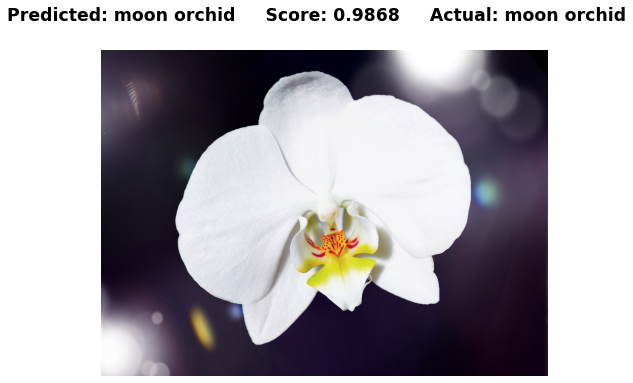

In [29]:
path = 'data/orchid_pixabay4.jpg'
actual = 'moon orchid'

predict_flower_type(path, actual)

algo-1-nukxt_1  | 172.18.0.1 - - [05/Sep/2020:04:44:09 +0000] "POST /invocations HTTP/1.1" 200 1647 "-" "-"


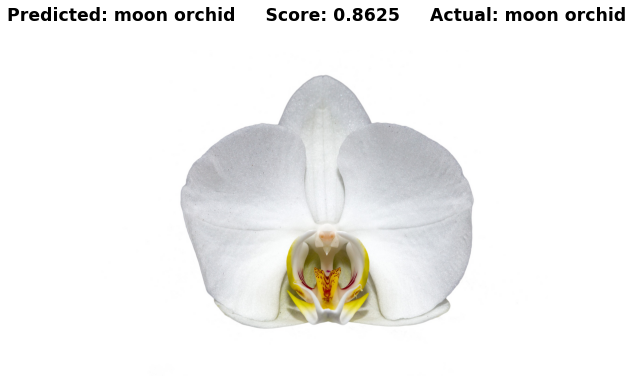

In [30]:
path = 'data/orchid_pixabay8.jpg'
actual = 'moon orchid'

predict_flower_type(path, actual)

In [31]:
!du -sh ./model.tar.gz

80M	./model.tar.gz


In [32]:
!tar --list --file=./model.tar.gz

1/
1/assets/
1/saved_model.pb
1/variables/
1/variables/variables.data-00000-of-00001
1/variables/variables.index


## **Wrap-up**

The final flower classification model is evaluated against a set of real-world flower images of different types from external sources to test how well it generalizes against unseen data. As a result, the model is able to classify all the unseen flower images correctly. The model size is **80 MB**, which could be considered as reasonably compact and efficient for edge deployment in production. In summary, the model seemed to be able to perform well on a given small set of unseen data and reasonably compact for production edge or web deployment.  

## **Proposed Enhancements**

Due to time and resources constraints, the solution here may not be providing the best practices or optimal designs and implementations. 
Here are some of the ideas which could be useful for anyone who is interested to contribute to improve the current solution.

-  Apply [**Data Augmentation**](https://www.tensorflow.org/tutorials/images/data_augmentation), i.e. random (but realistic) transformations such as rotation, flip, crop, brightness and contrast etc. on the training dataset to increase its size and diversity.

- Use [**Keras preprocessing layers**](https://keras.io/guides/preprocessing_layers/). [**Keras**](https://keras.io/) provides preprocessing layers such as **Image preprocessing layers** and **Image Data Augmentation preprocessing layers** which can be combined and exported as part of a Keras SavedModel. As a result, the model can accept raw images as input. 

- Convert the TensorFlow model (SavedModel format) to a [**TensorFlow Lite**](https://www.tensorflow.org/lite/) model (.tflite) for edge deployment and optimization on mobile and IoT devices.

- Optimize the TensorFlow Serving signature (**SignatureDefs** in SavedModel) to minimize the prediction output data structure and payload size. The current model prediction output returns the predicted class and score for all 102 flower types.

- Use [**TensorFlow Profiler**](https://www.tensorflow.org/guide/profiler) tools to track, analyze and optimize the performance of TensorFlow model.

- Use [**Intel Distribution of OpenVINO toolkit**](https://software.intel.com/content/www/us/en/develop/tools/openvino-toolkit.html) for the model's optimization and high-performance inference on Intel hardware such as CPU, iGPU, VPU or FPGA. 

- Optimize the Docker image size.

- Add unit test for the TensorFlow training script.

- Add unit test for the Dockerfile.

## **Next Steps**

After the machine learning workflow has been tested working as expected in the local environment, the next step is to fully migrate this workflow to [AWS Cloud](https://aws.amazon.com/) with [**Amazon SageMaker Notebook Instance**](https://docs.aws.amazon.com/sagemaker/latest/dg/nbi.html). In the next guide, I will demonstrate how to adapt this Jupyter notebook to run on SageMaker Notebook Instance as well as how to push the custom Docker image to the [**Amazon Elastic Container Registry (ECR)**](https://aws.amazon.com/ecr/) so that the whole workflow is fully hosted and managed in AWS.

## **Clean-up**

It is always a best practice to clean up obsolete resources or sessio at the end to reclaim compute, memory and storage resources as well as to save cost if clean up on cloud or distributed environment. For this scenario, the local SageMaker inference endpoint as well as SageMaker containers are deleted as shown below.

In [33]:
tf_local_predictor.delete_endpoint()

Gracefully stopping... (press Ctrl+C again to force)


In [34]:
! docker container ls -a

CONTAINER ID        IMAGE                                           COMMAND             CREATED             STATUS                                PORTS               NAMES
e8ed5762b897        sagemaker-custom-tensorflow-container-gpu:1.0   "serve"             28 seconds ago      Exited (137) Less than a second ago                       tmpjkjv5oc7_algo-1-nukxt_1
41a631f7fa19        sagemaker-custom-tensorflow-container-gpu:1.0   "train"             6 minutes ago       Exited (0) 34 seconds ago                                 tmpbb00tk19_algo-1-xxmq4_1


In [35]:
! docker rm $(docker ps -a -q)

e8ed5762b897
41a631f7fa19


In [36]:
! docker container ls -a

CONTAINER ID        IMAGE               COMMAND             CREATED             STATUS              PORTS               NAMES
